In [1]:
import porepy as pp
import numpy as np
from mat_utils import *
from fpm_0 import make_model
import scipy.sparse

model = make_model()
model.prepare_simulation()
# pp.run_time_dependent_model(
#     model, {"prepare_simulation": False, "progressbars": True}
# )

# pp.plot_grid(
#     model.mdg,
#     cell_value=model.pressure_variable,
#     vector_value=model.displacement_variable,
#     alpha=0.5,
# )

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()
mat, rhs = model.linear_system
# spy(mat)
# plt.show()
# plot_mat(mat)
# plt.show()

model._initialize_solver()
block_matrix = make_block_mat(model, mat)
eq_blocks = model.make_equations_indices()
var_blocks = model.make_variables_indices()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


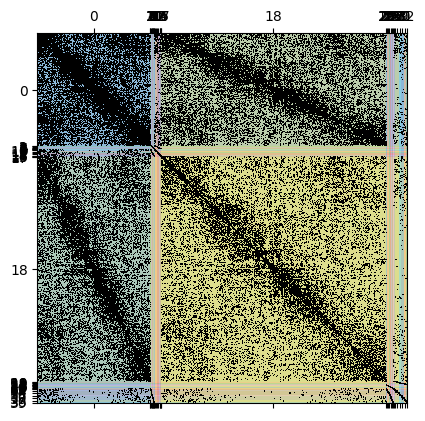

In [2]:
color_spy(block_mat=block_matrix)

In [3]:
A = concatenate_blocks(block_matrix, eq_blocks[0], var_blocks[0])
C1 = concatenate_blocks(block_matrix, eq_blocks[0], var_blocks[1])
C2 = concatenate_blocks(block_matrix, eq_blocks[1], var_blocks[0])
B = concatenate_blocks(block_matrix, eq_blocks[1], var_blocks[1])
D1 = concatenate_blocks(block_matrix, eq_blocks[0], var_blocks[2])
E1 = concatenate_blocks(block_matrix, eq_blocks[1], var_blocks[2])
D2 = concatenate_blocks(block_matrix, eq_blocks[2], var_blocks[0])
E2 = concatenate_blocks(block_matrix, eq_blocks[2], var_blocks[1])
F = concatenate_blocks(block_matrix, eq_blocks[2], var_blocks[2])
Phi = bmat([[E2, D2]])

# zeros_diag = F.diagonal() == 0
# ones = scipy.sparse.eye(F.shape[0], format='csr')
# ones.data[:] = zeros_diag
# F_inv = inv(F + ones)

# F_inv = inv(F)

F_inv = scipy.sparse.csr_matrix(np.linalg.pinv(F.A))


D1_Finv_D2 = D1 @ F_inv @ D2
E1_Finv_D2 = E1 @ F_inv @ D2
D1_Finv_E2 = D1 @ F_inv @ E2
E1_Finv_E2 = E1 @ F_inv @ E2

Ap = A - D1_Finv_D2
Bp = B - E1_Finv_E2
C1p = C1 - D1_Finv_E2
C2p = C2 - E1_Finv_D2

Bp_inv = PetscAMG(Bp)

S_Ap_fs = Ap + get_fixed_stress_stabilization(model)

S_Ap_fs_inv = PetscAMG(S_Ap_fs)

Omega_p_inv_fstress = OmegaInv(
    solve_momentum=Bp_inv, solve_mass=S_Ap_fs_inv, C1=C1p, C2=C2p
)

preconditioner = UpperBlockPreconditioner(
    F_inv=F_inv, Omega_inv=Omega_p_inv_fstress, Phi=Phi
)

permutation = make_permutations(
            model.eq_dofs, order=eq_blocks[2] + eq_blocks[1] + eq_blocks[0]
        )
permuted_mat = permutation @ mat @ model.permutation.T

Solve  took: 0.61


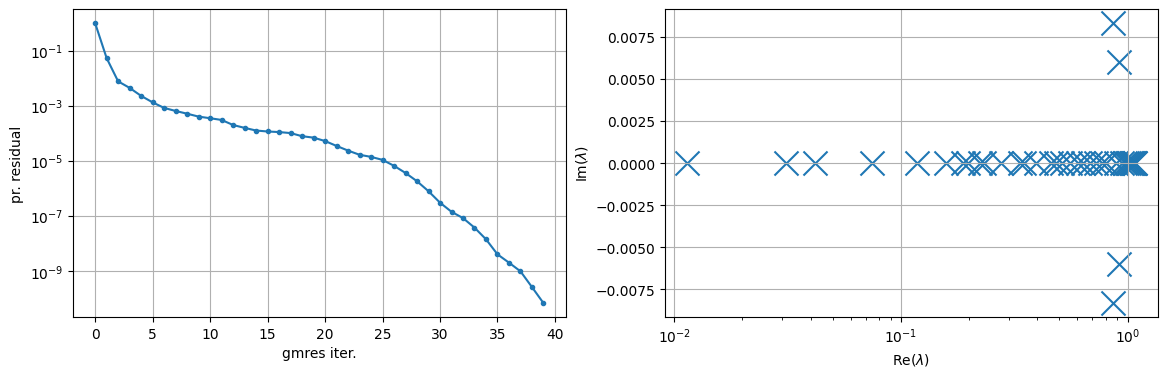

In [4]:
solve_petsc(permuted_mat, preconditioner, logx_eigs=True)
# solve_petsc(permuted_mat)

In [5]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.interface_darcy_flux(intf)],
        [model.contact_traction(sd_frac)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [("interface_darcy_flux_equation", intf)],  # 3
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 4
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_force_balance_equation", intf)], #5
    ],
)

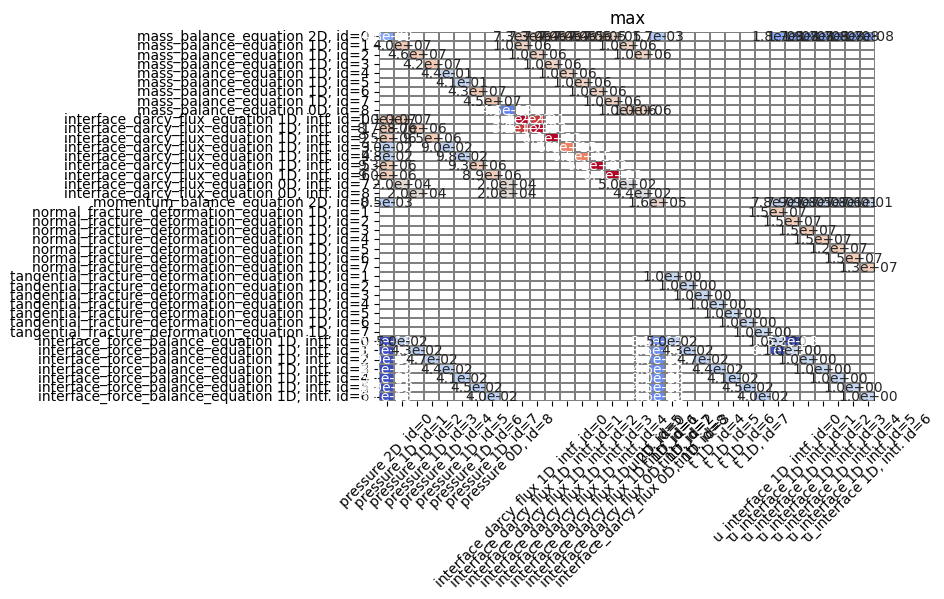

In [6]:
diagnostics = model.run_diagnostics(grouping=None)
model.plot_diagnostics(diagnostics, key='max')

In [7]:
diagnostics[1, 1]

{'is_empty_block': False,
 'variable_name': 'interface_darcy_flux',
 'equation_name': 'interface_darcy_flux_equation',
 'equation_printed_name': 'interface_darcy_flux_equation',
 'variable_printed_name': 'interface_darcy_flux',
 'block_dofs_row': array([2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369,
        2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380,
        2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391,
        2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402,
        2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413,
        2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424,
        2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435,
        2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446,
        2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457,
        2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468,
        2469, 

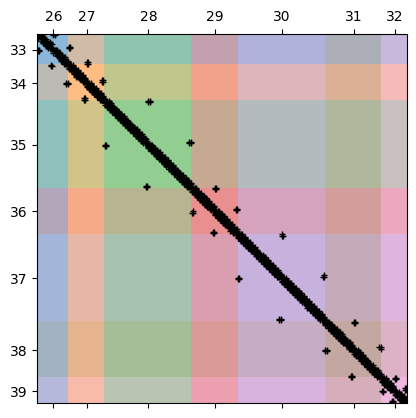

Solve  took: 0.0


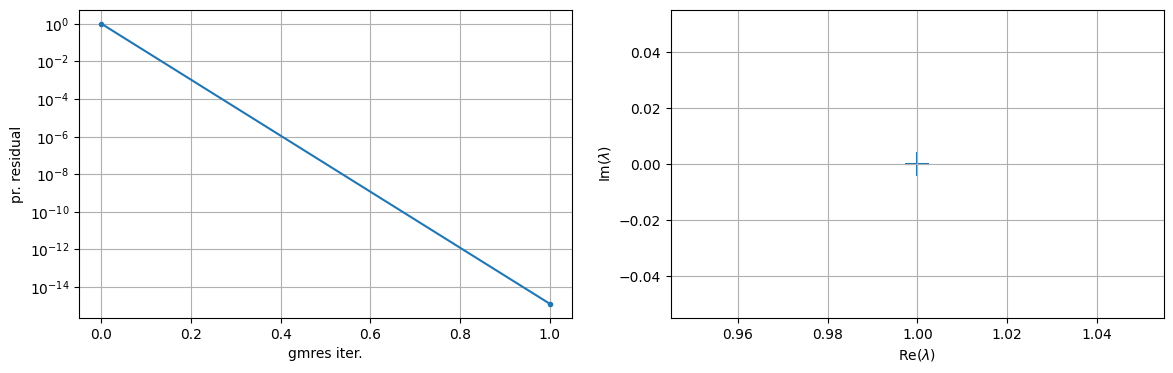

In [8]:
i = j = 5
x = concatenate_blocks(block_matrix, eq_idx[i], var_idx[j])
color_spy(block_matrix, eq_idx[i], var_idx[j])
plt.show()
solve_petsc(x, PetscAMG(x))